In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import os, random
import sys
sys.path.append('../')
import astropy

from data import *

random.seed(42)

mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 16


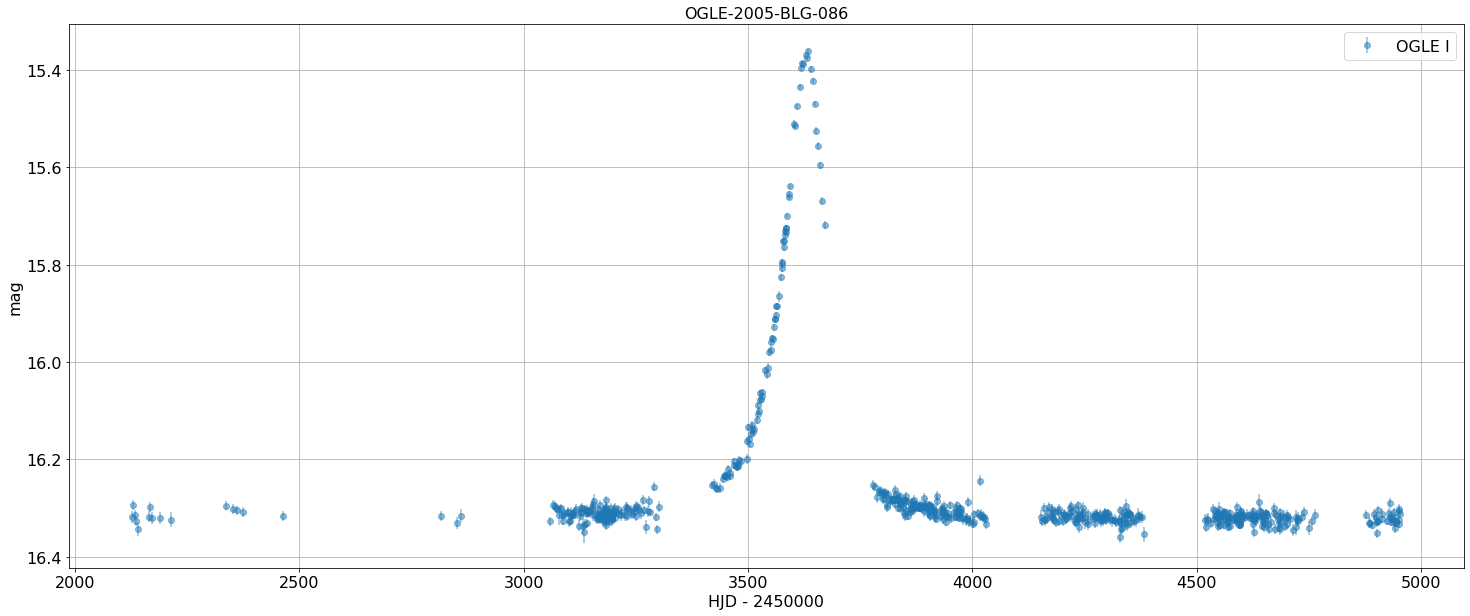

In [2]:
event_dir = '../data/OB05086/'
event = Data()
t = Table.read(event_dir + 'phot.dat', format='ascii', 
    names=('HJD', 'mag', 'mag_err'))
t['HJD'] = t['HJD'] + 2450000
t.meta = {'observatory':'OGLE', 'filter':'I'}
event.tables.append(t)
mask = np.ones(len(t['HJD']), dtype=bool)
event.masks.append(mask)
event.coordinates = SkyCoord("18h04m45.71s", "-26d59m15.2s")
event.event_name = 'OGLE-2005-BLG-086'
event.units = 'magnitudes'



fig, ax = plt.subplots(figsize=(25, 10))
# event.remove_worst_outliers(window_size=11, mad_cutoff=7)
event.plot(ax)

# Query JPL horizons and get Eath's orbital elements for each $t_i$


In [3]:
from astroquery.jplhorizons import Horizons
from astropy.time import Time
from astropy import units as u

start = Time(event.tables[0]['HJD'][0], format='jd')
stop = Time(event.tables[0]['HJD'][-1], format='jd')

epochs={'start':start.iso[:10], 'stop':stop.iso[:10], 'step':'6h'}
obj = Horizons(id='399', id_type='id', epochs=epochs)

In [4]:
elements = obj.elements()
elements

targetname,datetime_jd,datetime_str,e,q,incl,Omega,w,Tp_jd,n,M,nu,a,Q,P
---,d,---,---,AU,deg,deg,deg,d,deg / d,deg,deg,AU,AU,d
str11,float64,str30,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
Earth (399),2452127.5,A.D. 2001-Aug-06 00:00:00.0000,0.017281306875,0.981938606852,0.000991904027282,291.803303015,172.825462155,2452279.57331,0.986783885386,209.936510998,208.966484779,0.999206195753,1.01647378465,364.821523062
Earth (399),2452127.75,A.D. 2001-Aug-06 06:00:00.0000,0.0172585463502,0.981975420522,0.000903476959028,289.528839842,175.134106836,2452279.61358,0.98676267529,210.146686502,209.171712448,0.999220514078,1.01646560763,364.829364765
Earth (399),2452128.0,A.D. 2001-Aug-06 12:00:00.0000,0.0172342816619,0.982015579138,0.000814347705532,286.646634965,178.046068901,2452279.64975,0.986738690739,210.361323873,209.38138345,0.999236705976,1.01645783281,364.838232633
Earth (399),2452128.25,A.D. 2001-Aug-06 18:00:00.0000,0.0172085691881,0.9820589967,0.000725683590921,282.929568522,181.78835225,2452279.68168,0.986711977096,210.580543032,209.595614067,0.999254741048,1.0164504854,364.848110043
Earth (399),2452128.5,A.D. 2001-Aug-07 00:00:00.0000,0.0171814676463,0.982105582603,0.000639182896525,278.04371445,186.6947715,2452279.70926,0.986682583179,210.80445933,209.814516061,0.999274586582,1.01644359056,364.858979106
Earth (399),2452128.75,A.D. 2001-Aug-07 06:00:00.0000,0.0171530380466,0.98215524174,0.000557433470692,271.505455749,193.248836767,2452279.73235,0.98665056118,211.0331835,210.038196626,0.999296207609,1.01643717348,364.870820698
Earth (399),2452129.0,A.D. 2001-Aug-07 12:00:00.0000,0.0171233436603,0.982207874567,0.00048448202273,262.666241602,202.098996635,2452279.75083,0.9866159666,211.266821571,210.266758301,0.999319566938,1.01643125931,364.883614483
Earth (399),2452129.25,A.D. 2001-Aug-07 18:00:00.0000,0.01709245,0.98226337715,0.000426503201134,250.858208145,213.913017488,2452279.7646,0.986578858207,211.505474776,210.500298871,0.999344625189,1.01642587323,364.897338926


# Computing the projection of Earth's orbit using the orbital elements method

## Test np.gradient function

In [5]:
from scipy.signal import medfilt

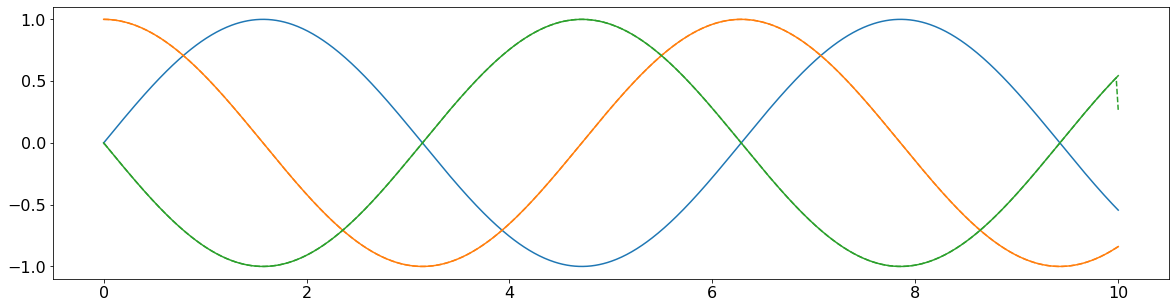

In [6]:
x = np.linspace(0, 10, 1000)
y = np.sin(x)

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(x, y, 'C0-')
ax.plot(x, np.cos(x), 'C1-')
ax.plot(x, np.gradient(y, 0.01001001), 'C1--')
ax.plot(x, -np.sin(x), 'C2-')
ax.plot(x, np.gradient(np.gradient(y, 0.01001001), 0.01001001), 'C2--')

In [7]:
coordinates_ecliptic = event.coordinates.transform_to('geocentrictrueecliptic')
lambda_0 = coordinates_ecliptic.lon.value*(np.pi/180)
beta_0  = coordinates_ecliptic.lat.value*(np.pi/180)

t = np.array(elements['datetime_jd']) # JD
e = np.array(elements['e'])
tp = np.array(elements['Tp_jd']) # JD
n = (2*np.pi/365.25) # mean motion
Phi_gamma = (77.86)*np.pi/180 # true anomaly at vernal eq. on J2000
r_sun = 1 - e*np.cos(n*(t - tp)) # to 1st order in e
lambda_sun = n*(t - tp) - Phi_gamma + 2*e*np.sin(n*(t - tp)) # to 1st order in e

gamma_e = lambda t: (1 - e*np.cos(n*(t - tp)))*np.sin((n*(t - tp) -\
    Phi_gamma + 2*e*np.sin(n*(t - tp)) - lambda_0))
gamma_n = lambda t: -(1 - e*np.cos(n*(t - tp)))*np.sin(beta_0)*\
    np.cos(n*(t - tp) - Phi_gamma + 2*e*np.sin(n*(t - tp)) - lambda_0)

delta_t = t[1] - t[0]
gamma_e_dot = np.gradient(gamma_e(t), delta_t)
gamma_n_dot = np.gradient(gamma_n(t), delta_t)

# Smooth out the derivative to get rid of discontinuous jumps
gamma_e_dot = medfilt(gamma_e_dot, 7)
gamma_n_dot = medfilt(gamma_n_dot, 7)

gamma_e_ddot = np.gradient(gamma_e_dot, delta_t)
gamma_n_ddot = np.gradient(gamma_n_dot, delta_t)
gamma_e_ddot = medfilt(gamma_e_ddot, 7)
gamma_n_ddot = medfilt(gamma_n_ddot, 7)

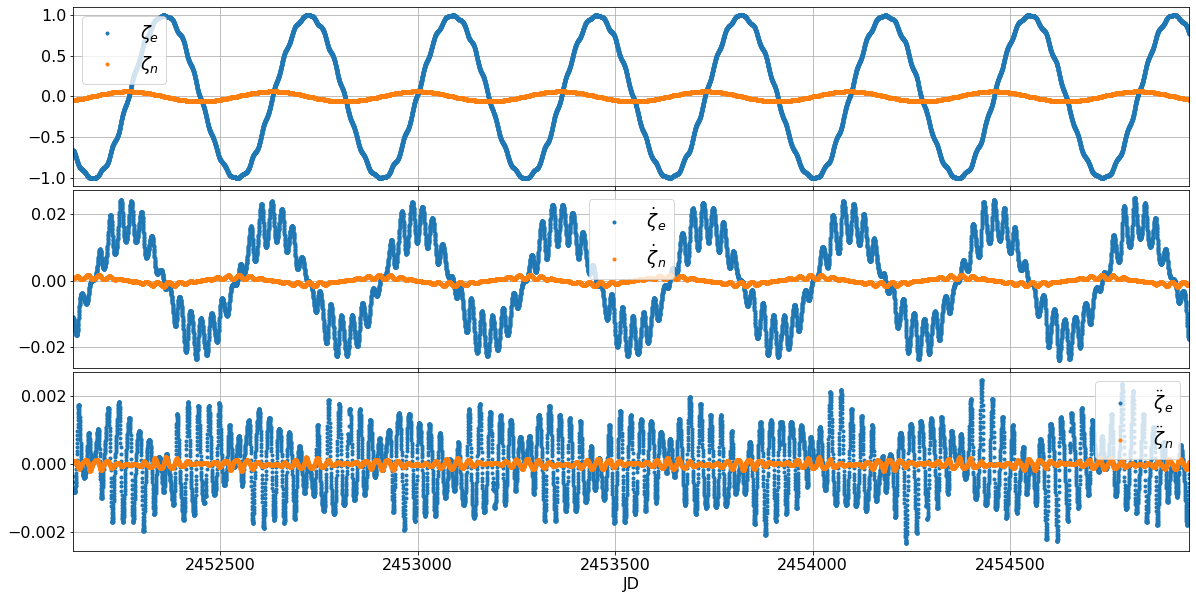

In [8]:
fig, ax = plt.subplots(3,1, figsize=(20, 10), sharex=True)
fig.subplots_adjust(hspace=0.02)
ax[0].plot(t, gamma_e(t), 'C0.', label='$\zeta_e$')
ax[0].plot(t, gamma_n(t), 'C1.', label='$\zeta_n$')
ax[1].plot(t, gamma_e_dot, 'C0.', label='$\dot\zeta_e$')
ax[1].plot(t, gamma_n_dot, 'C1.', label='$\dot\zeta_n$')
ax[2].plot(t, gamma_e_ddot, 'C0.', label='$\ddot\zeta_e$')
ax[2].plot(t, gamma_n_ddot, 'C1.', label='$\ddot\zeta_n$')
ax[2].set_xlabel('JD')
for a in ax.ravel():
    a.grid()
    a.legend(prop={'size': 18})
    a.set_xlim(t[0], t[-1])
    
# plt.savefig('gamma_vector.pdf', bbox_inches='tight')

Text(0, 0.5, '$\\zeta_n$')

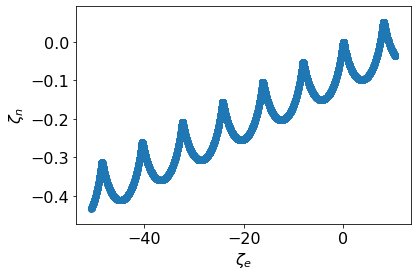

In [9]:
delta_gamma_e = lambda t: gamma_e(t) - gamma_e(t[2000]) - (t - t[2000])*gamma_e_dot[2000]
delta_gamma_n = lambda t: gamma_n(t) - gamma_n(t[2000]) - (t - t[2000])*gamma_n_dot[2000]

fig, ax = plt.subplots()
ax.scatter(delta_gamma_e(t), delta_gamma_n(t))
ax.set_xlabel(r'$\zeta_e$')
ax.set_ylabel(r'$\zeta_n$')

# Computing the projection of Eath's orbit directly

In [10]:
t = np.array(elements['datetime_jd']) # JD

from astropy.coordinates import get_body_barycentric_posvel
pos, vel = get_body_barycentric_posvel('earth', Time(t, format='jd', scale='tdb'))

t0 = 2453630.562
pos_t0, vel_t0 = get_body_barycentric_posvel('earth-moon-barycenter', Time(t0, format='jd', scale='tdb'))

s_t0 = -pos_t0.xyz.value.reshape((1, 3))
s_t = -pos.xyz.value.T
v_t = -vel.xyz.value.T
v_t0 = -vel_t0.xyz.value.reshape((1, 3))

In [13]:
def project_vector_onto_sky(matrix, coordinates):
    """
    This function takes a 3D cartesian vector specified
    in the ICRS coordinate system and evaluated at differrent
    times (t_i,...t_N) and projects it onto a spherical coordinate
    system on the plane of the sky with the origin at the position
    defined by the coordinates.
    
    Parameters
    ----------
    matrix : ndarray
        Matrix of shape (times_len, 3)
    coordinates : astropy.coordinates.SkyCoord
        Coordinates on the sky.
    """

    # Vector normal to the plane of the sky in ICRS coordiantes
    direction = np.array(coordinates.cartesian.xyz.value)
    
    # Unit vector pointing north in ICRS coordinates
    e_north = np.array([0., 0., 1.])

    # Sperical unit vectors of the coordinate system defined
    # on the plane of the sky which is perpendicular to the
    # source star direction
    e_east_sky = np.cross(e_north, direction)
    e_east_sky /= np.linalg.norm(e_east_sky)
    e_north_sky = np.cross(direction, e_east_sky)

    east_component  = np.dot(matrix, e_east_sky)
    north_component = np.dot(matrix, e_north_sky)
    
    return east_component, north_component
    
t0 = 2453628.
t = t.reshape((len(t), 1))
delta_s = s_t - s_t0 - (t - t0)*v_t0

zeta_e, zeta_n = project_vector_onto_sky(s_t, event.coordinates)
zeta_dot_e, zeta_dot_n = project_vector_onto_sky(v_t, event.coordinates)
delta_zeta_e, delta_zeta_n = project_vector_onto_sky(delta_s, event.coordinates)


print(np.shape(zeta_dot_e))
zeta_ddot_e = np.gradient(zeta_dot_e, delta_t)
zeta_ddot_n = np.gradient(zeta_dot_n, delta_t)

(11305,)


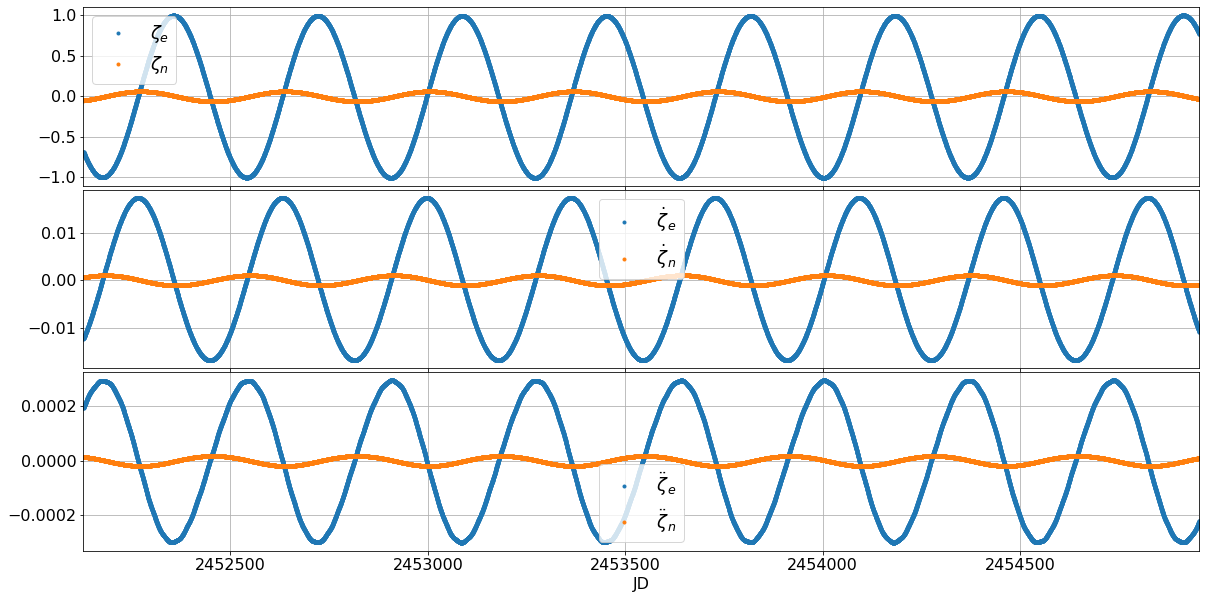

In [14]:
fig, ax = plt.subplots(3,1, figsize=(20, 10), sharex=True)
fig.subplots_adjust(hspace=0.02)

ax[0].plot(t, zeta_e, 'C0.', label='$\zeta_e$')
ax[0].plot(t, zeta_n, 'C1.', label='$\zeta_n$')
ax[1].plot(t, zeta_dot_e, 'C0.', label='$\dot\zeta_e$')
ax[1].plot(t, zeta_dot_n, 'C1.', label='$\dot\zeta_n$')
ax[2].plot(t, zeta_ddot_e, 'C0.', label='$\ddot\zeta_e$')
ax[2].plot(t, zeta_ddot_n, 'C1.', label='$\ddot\zeta_n$')
ax[2].set_xlabel('JD')
for a in ax.ravel():
    a.grid()
    a.legend(prop={'size': 18})
    a.set_xlim(t[0], t[-1])
    
    
# plt.savefig('gamma_vector.pdf', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(20, 10), sharex=True)
fig.subplots_adjust(hspace=0.02)

ax[0].plot(t, delta_zeta_e, 'C0.', label='$\zeta_e$')
ax[0].plot(t, delta_zeta_n, 'C1.', label='$\zeta_n$')
# ax[1].plot(t, zeta_dot_e, 'C0.', label='$\dot\zeta_e$')
# ax[1].plot(t, zeta_dot_n, 'C1.', label='$\dot\zeta_n$')
# ax[2].plot(t, gamma_e_ddot, 'C0.', label='$\ddot\zeta_e$')
# ax[2].plot(t, gamma_n_ddot, 'C1.', label='$\ddot\zeta_n$')
ax[2].set_xlabel('JD')
for a in ax.ravel():
    a.grid()
    a.legend(prop={'size': 18})
    a.set_xlim(t[0], t[-1])
    
# plt.savefig('gamma_vector.pdf', bbox_inches='tight')

In [ ]:
print(delta_zeta_e)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(delta_zeta_e, delta_zeta_n)
ax.set_xlabel(r'$\zeta_e$')
ax.set_ylabel(r'$\zeta_n$')

# Testing different parametrizations

In [ ]:
def compute_u(t_, u0, t0, omegaE, psi, piE):
    delta_gamma_e = lambda t: gamma_e(t) - gamma_e(t0) - (t - t0)*gamma_e_dot(t0)
    delta_gamma_n = lambda t: gamma_n(t) - gamma_n(t0) - (t - t0)*gamma_n_dot(t0)
#     delta_gamma_e_ddot = lambda t: gamma_e_ddot(t)
#     delta_gamma_n_ddot= lambda t: gamma_n_ddot(t)

    delta_gamma_e_interp = np.interp(t_, t, delta_gamma_e(t))
    delta_gamma_n_interp = np.interp(t_, t, delta_gamma_n(t))
    
    u_e = u0*np.sin(psi) + (t_ - t0)*omegaE*np.cos(psi) + piE*delta_gamma_e_interp
    u_n = u0*np.cos(psi) - (t_ - t0)*omegaE*np.sin(psi) + piE*delta_gamma_n_interp

    return u_e, u_n
    
t_ = np.linspace(t[0], t[-1], 1000)

t0 = 0.5*(t[-1] + t[0])
tE = 60.

u_e, u_n = compute_u(t_, 0.4, t0, 1/tE, 45*(np.pi/180), .9)
u_e_linear, u_n_linear = compute_u(t_, 0.4, t0, 1/tE, 45*(np.pi/180), 0.)

fig, ax = plt.subplots(figsize=(8,8))

ax.plot(u_e, u_n, color='C0', lw=2.)
ax.plot(u_e_linear, u_n_linear, color='black', lw=1.5, alpha=0.7)
ax.axvline(0., color='grey', linestyle='dashed', alpha=0.7)
ax.axhline(0., color='grey', linestyle='dashed', alpha=0.7)

# ax.grid()
ax.set_xlabel(r'$u_e$')
ax.set_ylabel('$u_n$')
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.invert_xaxis()

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot((t_ - t0)/tE, np.sqrt(u_e**2 + u_n**2), color='black', lw=2.)
ax.grid()
ax.set_xlabel(r'$(t - t_0)/t_E$')
ax.set_ylabel(r'$u$')

### Alternative parametrization

In [ ]:
def compute_u_alternative(t_, u0p, t0p, vop, ap, av):
    gamma_w_ddot_t0p = np.interp(t0p, t, gamma_w_ddot)
    gamma_n_ddot_t0p = np.interp(t0p, t, gamma_n_ddot)
    gamma_w_dot_t0p = np.interp(t0p, t, gamma_w_dot)
    gamma_n_dot_t0p = np.interp(t0p, t, gamma_n_dot)
    gamma_w_t0p = np.interp(t0p, t, gamma_w)
    gamma_n_t0p = np.interp(t0p, t, gamma_n)

    piE = np.sqrt((ap**2 + av**2)/(gamma_w_ddot_t0p**2 + gamma_n_ddot_t0p**2))
    sinphi = piE*(gamma_w_ddot_t0p*av - gamma_n_ddot_t0p*ap)/(av**2 + ap**2)
    cosphi = piE*(gamma_n_ddot_t0p*av + gamma_w_ddot_t0p*ap)/(av**2 + ap**2)
    omegaE = np.sqrt(piE**2*(gamma_n_dot_t0p**2 + gamma_n_dot_t0p**2) - v0p**2)
#     sinpsi = (gamma_n_dot_t0p*piE + v0p*sinphi)/omegaE
#     cospsi = (gamma_w_dot_t0p*piE - v0p*sinphi)/omegaE

    
    gamma_w_interp = np.interp(t_, t, gamma_w)
    gamma_n_interp = np.interp(t_, t, gamma_n)
    
    u_w = u0p*sinphi + piE*(gamma_w_interp - gamma_w_t0p) + (vop*cosphi - piE*gama_w_dot_t0)(t_ - t0p)
    u_n = u0p*cosphi + piE*(gamma_n_interp - gamma_n_t0p) + (-vop*sinphi - piE*gama_n_dot_t0)(t_ - t0p)

    return u_w, u_n

In [ ]:
u_w, u_n = compute_u(t_, 0.01, t0, 1/tE*0.4, 0.1, 0.2)


fig, ax = plt.subplots(figsize=(8,8))
ax.plot(u_w, u_n, color='black', lw=2.)
ax.axvline(0., color='grey', linestyle='dashed', alpha=0.7)
ax.axhline(0., color='grey', linestyle='dashed', alpha=0.7)
# ax.grid()
ax.set_xlabel(r'$u_w$')
ax.set_ylabel('$u_n$')
# ax.set_xlim(-10, 10)
# ax.set_ylim(-10, 10)

$\theta_E=\sqrt{\frac{4GM}{c^2}\left(\frac{1}{D_L}-\frac{1}{D_S}\right)}$